#### INTRO

In this script, we perform a Vader-based sentiment analysis of the answers to the consultation by first cleaning the text. Text cleaning is done by removing:
- Punctuation (unlikley that emoticons are used in the context of an official consultation)
- Non-alphabetic tokens
- Stop-words (default set).

We then compare the sentiment scores for the answers with and without stopwords.

#### Imports and Set Up

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords


/Users/alessia/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
cwd = os.chdir("/Users/alessia/Documents/DataScience/NLP_Project/Data")
cwd

#### Get Data

In [3]:
cons1_df = pd.read_csv("/Users/alessia/Documents/DataScience/NLP_Project/Outputs/cons1_SA_df.csv")

In [4]:
cons1_df.columns.values;

#### Data manipulation: word tokenisation and text cleaning

Select columns that contains the answers to be tokenised for punctuation-/non-alphabetic token-/stopword-removal and sentiment analysis.

In [5]:
# Get columns' index
idx_Q1 = cons1_df.columns.get_loc(str([col for col in cons1_df if 'census methods' in str(col)][0]))
idx_Q4 = cons1_df.columns.get_loc(str([col for col in cons1_df if '4. 1. ' in str(col)][0]))
idx_Q5 = cons1_df.columns.get_loc(str([col for col in cons1_df if '5. 1.' in str(col)][0]))
idx_Q8 = cons1_df.columns.get_loc(str([col for col in cons1_df if '8.' in str(col)][0]))

In [6]:
# Save them in a dictionary
col_idx_dict = {"Q1_clean":idx_Q1, "Q4_clean":idx_Q4, "Q5_clean":idx_Q5, "Q8_clean":idx_Q8}

#print(col_idx_dict)
#print(col_idx_dict.items())
#print(col_idx_dict.values())

In [7]:
#Checks
print([idx_Q1, idx_Q4, idx_Q5, idx_Q8])
cons1_df.iloc[:, [idx_Q1, idx_Q4, idx_Q5, idx_Q8]].head(2);

[40, 44, 46, 49]


Define function to clean text.

In [8]:
# Define function to clean answer text
import string

from nltk.tokenize.moses import MosesDetokenizer
            detokenizer = MosesDetokenizer()
    

def clean_text(data, col_ind, stop_words) :
    """Return cleaned text for the specified data columns: 
    removed punctuation, removed non-alphabetic tokens, removed stop-words"""
    
    import pandas as pd
    from nltk.tokenize import word_tokenize
    
    # empty list collector
    filtered_answer_bag = []
    
    for answer in data.iloc[:, col_ind] :   
        
        # no answer was provided, return NA
        if pd.isnull(answer) : 
            filtered_answer_bag.append(np.nan)
            
            # an answer was provided    
        else : 
                
            # 1. word-tokenise the answer
            words = word_tokenize(answer)
        
            # 2. convert to lower case
            words = [w.lower() for w in words]
        
            # 3. remove punctuation from each word
            table = str.maketrans('', '', string.punctuation)
            words = [w.translate(table) for w in words]

            # 4. remove remaining tokens that are not alphabetic
            only_words = [w for w in words if w.isalpha()]

            # 5. filter out stop words from each answer
            filtered_answer = [w for w in only_words if not w in stop_words]
        
            # 6. untokenise the sentence: return one unique string for each answer in prep for sentiment analysis
            filtered_answer = detokenizer.detokenize(filtered_answer, return_str=True)

            filtered_answer_bag.append(filtered_answer)
    
    return(filtered_answer_bag)

Clean the text.

In [9]:
# Set stop words
stop_words = set(stopwords.words('english'))

# do we want to keep in "no"? "yes" is not a stopword...

In [10]:
# Create new dataset columns containing the cleaned texts

for q, idx in col_idx_dict.items() :

    result = clean_text(cons1_df, idx, stop_words = stop_words)
    
    cons1_df.loc[:, q] = result


In [11]:
# Checks
cons1_df.columns.values;
cons1_df.head(6);

#### Sentiment Analysis on cleaned answers

In [1]:
# Define function to calculate polarity score for the answers in our dataset

# import key modules
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
    

def get_sentiment_score(data, col_ind) :
    """ Return list of polarity scores for values in the specified column """
    
    # empty list collector of scores
    sentiment_bag = []
    
    for answer in data.iloc[:, col_ind] :
        
        # no answer was provided, return NA
        if pd.isnull(answer) : 
            sentiment_bag.append(np.nan)
            
        else :
            sentiment_bag.append(analyser.polarity_scores(answer)['compound'])
    
    return(sentiment_bag)
    

/Users/alessia/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [13]:
# Get columns' index
idx_Q1 = cons1_df.columns.get_loc('Q1_clean')
idx_Q4 = cons1_df.columns.get_loc('Q4_clean')
idx_Q5 = cons1_df.columns.get_loc('Q5_clean')
idx_Q8 = cons1_df.columns.get_loc('Q8_clean')

In [14]:
# Save them in a dictionary
col_idx_dict = {"Q1_cl_sentiment":idx_Q1, "Q4_cl_sentiment":idx_Q4, "Q5_cl_sentiment":idx_Q5, "Q8_cl_sentiment":idx_Q8}

#print(col_idx_dict)
#print(col_idx_dict.items())
#print(col_idx_dict.values())

In [15]:
# Create new dataset columns with sentiment polarity scores of cleaned answer texts

for q, idx in col_idx_dict.items():
    
    result = get_sentiment_score(cons1_df, idx)
    cons1_df.loc[:, q] = result

In [35]:
# Take a look at the result
cons1_df.iloc[3:7:, [idx_Q1, -4, idx_Q4, -3, idx_Q5, -2, idx_Q8, -1]];
cons1_df.loc[3:7:, ["Q1_Sentiment", "Q1_cl_sentiment","Q4_Sentiment", "Q4_cl_sentiment",
                          "Q5_Sentiment", "Q5_cl_sentiment","Q8_Sentiment", "Q8_cl_sentiment"]];

# some changed drammatically!!!!

In [17]:
# Summary satistics
cons1_df.loc[:, ["Q1_Sentiment", "Q1_cl_sentiment","Q4_Sentiment", "Q4_cl_sentiment",
                          "Q5_Sentiment", "Q5_cl_sentiment","Q8_Sentiment", "Q8_cl_sentiment"]].describe()

Q1_Sentiment  Q1_cl_sentiment  Q4_Sentiment  Q4_cl_sentiment  \
count    736.000000       736.000000    523.000000       523.000000   
mean       0.388333         0.452973      0.073410         0.128613   
std        0.523643         0.488071      0.515057         0.500117   
min       -0.981700        -0.932500     -0.983000        -0.959500   
25%        0.000000         0.000000     -0.318200        -0.226300   
50%        0.493900         0.585900      0.000000         0.025800   
75%        0.866425         0.880550      0.440400         0.503950   
max        0.999800         0.999600      0.999900         0.999800   

       Q5_Sentiment  Q5_cl_sentiment  Q8_Sentiment  Q8_cl_sentiment  
count    396.000000       396.000000    490.000000       490.000000  
mean       0.338060         0.389064      0.092375         0.157662  
std        0.425649         0.402639      0.575458         0.561832  
min       -0.904200        -0.904200     -0.969100        -0.966300  
25%        0.000000         0.000000     -0.361200        -0.273200  
50%        0.440400         0.440400      0.000000         0.102700  
75%        0.690275         0.700300      0.633900         0.690800  
max        0.995400         0.997200      0.998800         0.998500

#### Comparison of the two sentiment scores and Validation

In [30]:
# pairwise correlations
cons1_df.loc[:, ["Q1_Sentiment", "Q1_cl_sentiment"]].corr(method='pearson').iloc[:1,1:]

Q1_cl_sentiment
Q1_Sentiment         0.850235

In [31]:
cons1_df.loc[:, ["Q4_Sentiment", "Q4_cl_sentiment"]].corr(method='pearson').iloc[:1,1:]

Q4_cl_sentiment
Q4_Sentiment          0.90749

In [32]:
cons1_df.loc[:, ["Q5_Sentiment", "Q5_cl_sentiment"]].corr(method='pearson').iloc[:1,1:]

Q5_cl_sentiment
Q5_Sentiment         0.900928

In [33]:
cons1_df.loc[:, ["Q8_Sentiment", "Q8_cl_sentiment"]].corr(method='pearson').iloc[:1,1:]

Q8_cl_sentiment
Q8_Sentiment         0.863645

A rather good agreement between the polarity score of raw and filtered/cleaned text, especially for question 4 and 5.

Let's visualise how the polarity score changes for the individual answers.

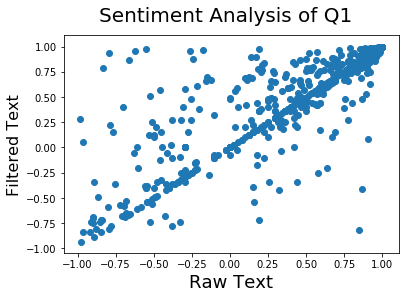

In [190]:
fig = plt.figure()
plt.scatter(cons1_df['Q1_Sentiment'], cons1_df['Q1_cl_sentiment'])
fig.suptitle('Sentiment Analysis of Q1', fontsize=20)
plt.xlabel('Raw Text', fontsize=18)
plt.ylabel('Filtered Text', fontsize=16)
fig

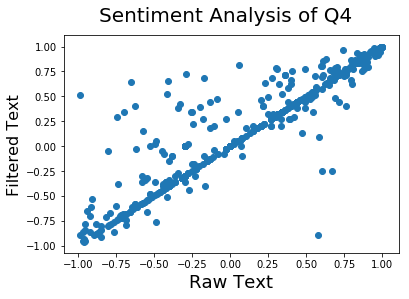

In [191]:
fig = plt.figure()
plt.scatter(cons1_df['Q4_Sentiment'], cons1_df['Q4_cl_sentiment'])
fig.suptitle('Sentiment Analysis of Q4', fontsize=20)
plt.xlabel('Raw Text', fontsize=18)
plt.ylabel('Filtered Text', fontsize=16)
fig

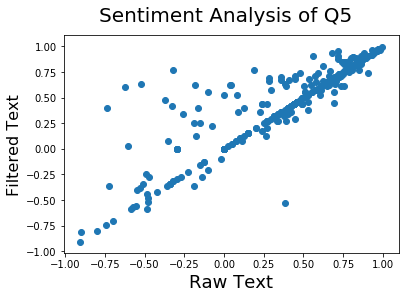

In [192]:
fig = plt.figure()
plt.scatter(cons1_df['Q5_Sentiment'], cons1_df['Q5_cl_sentiment'])
fig.suptitle('Sentiment Analysis of Q5', fontsize=20)
plt.xlabel('Raw Text', fontsize=18)
plt.ylabel('Filtered Text', fontsize=16)
fig

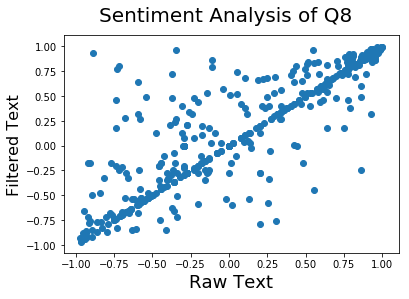

In [193]:
fig = plt.figure()
plt.scatter(cons1_df['Q8_Sentiment'], cons1_df['Q8_cl_sentiment'])
fig.suptitle('Sentiment Analysis of Q8', fontsize=20)
plt.xlabel('Raw Text', fontsize=18)
plt.ylabel('Filtered Text', fontsize=16)
fig

There seem to be quite a few answers that get an opposite sentiment score (from negative to positive, and vice versa) if the text is cleaned/filtered before analysis vs it is left raw.

In particular, more negative scores tend to become positive after text cleaning. Could be due to the removal of negation-related words (captured in the default stop-word set)?

In [95]:
print(cons1_df.loc[[3,7, 10, 11, 12, 332, 473, 855, 932], ["Q1_Sentiment", "Q1_cl_sentiment"]])

     Q1_Sentiment  Q1_cl_sentiment
3   -0.4585        0.5719         
7    0.1887       -0.7193         
10   0.9337        0.8965         
11   0.8657        0.9764         
12  -0.1513        0.7003         
332 -0.3089        0.4019         
473  0.0000        0.0000         
855  0.9750        0.9897         
932 -0.4503        0.1531         


In [97]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

cons1_df.iloc[[3,7,10, 11, 12, 332, 473, 855, 932], [40]];

In [99]:
# Save dataset

cons1_df.to_csv('/Users/alessia/Documents/DataScience/NLP_Project/Outputs/cons1_cleantext_SA_df.csv', encoding='utf-8')